In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
df["intercept"] = 1

In [8]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [9]:
# Split features & group variables
G = X[["store_id", "store_primary_category"]]
X = X.drop(["store_id", "store_primary_category"], axis = 1)

In [10]:
# Enforce dtype of group variables
G["store_id"] = G["store_id"].astype("str") 

In [11]:
# Nest store_id into store category
G_nested = gpb.get_nested_categories(G["store_primary_category"], G["store_id"])
G = np.column_stack((G["store_primary_category"], G_nested))

In [12]:
G

array([['dessert', 3173],
       ['cafe', 2397],
       ['smoothie', 8938],
       ['mexican', 6352],
       ['cafe', 2263],
       ['american', 219],
       ['sandwich', 8402],
       ...,
       ['mexican', 6142],
       ['pizza', 7940],
       ['italian', 4729],
       ['pizza', 7598],
       ['italian', 5048],
       ['american', 765],
       ['american', 170]], dtype=object)

In [13]:
train_end = int(len(df) * 0.6)

In [14]:
val_end = train_end + int(len(df) * 0.2)

In [15]:
# Target encoder for non-group categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "order_protocol"])

# Testing & diagnostics

In [16]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [17]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [18]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [19]:
# Create random effects model
model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gamma",
        seed = random_state
    )

In [20]:
# Train mixed effects model
model.fit(X = X_train, y = y_train, params = {"std_dev": True})

[GPBoost] [Warning] The linear regression covariate data matrix (fixed effect) is rank deficient. This is not necessarily a problem when using gradient descent. If this is not desired, consider dropping some columns / covariates.


In [21]:
# Make predictions on test data
preds = model.predict(X_pred = X_test, group_data_pred = G_test, predict_var = True)

In [24]:
preds

{'mu': array([5509.8644, 3409.2665, 4091.8263, 3684.8786, 4776.9368, 3129.5612,
        2370.9431, ..., 2050.844 , 2604.4508, 1695.8267, 2179.1208,
        3473.1346, 3935.761 , 2643.3401]),
 'cov': None,
 'var': array([2233674.8929,  880608.7536, 1276488.4739, 1018193.7691,
        1726728.9095,  757962.4745,  414205.3623, ...,  322753.5969,
         517060.9667,  215164.4866,  366909.6478,  994401.8521,
        1247423.5083,  514096.006 ])}

In [23]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds["mu"]
df_pred["sd"] = np.sqrt(preds["var"])
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [25]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
939.7922755109722
MAPE:
0.2377336867501777


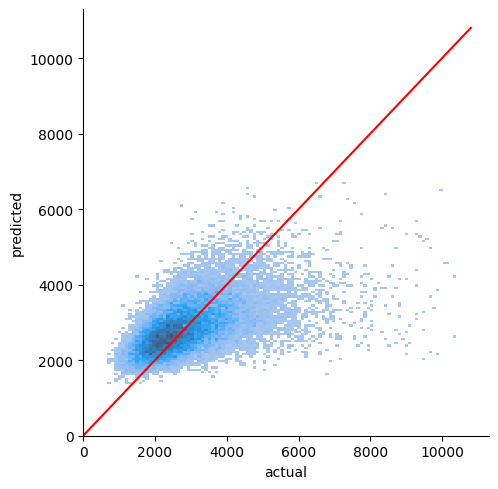

In [26]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

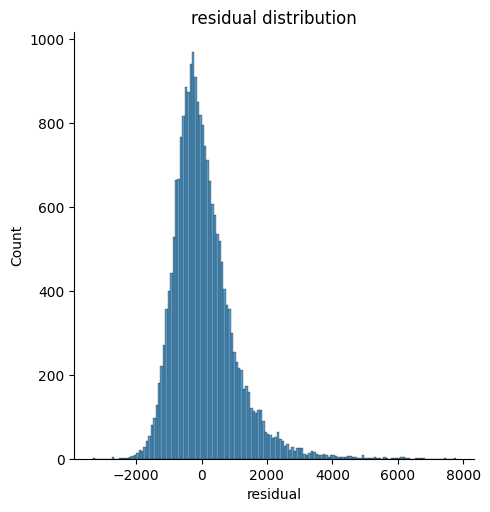

In [27]:
# Residual distribution
_ = sns.displot(df_pred["residual"])
_ = plt.title("residual distribution")

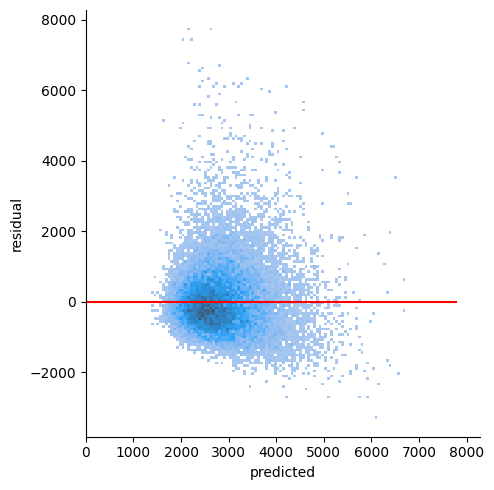

In [28]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

In [29]:
model.summary()

Model summary:
     Log-lik          AIC          BIC
-710856.8600 1421773.7200 1422055.3900
Nb. observations: 88345
Nb. groups: 73 (Group_1), 8951 (Group_2)
-----------------------------------------------------
Covariance parameters (random effects):
         Param.
Group_1  0.9858
Group_2  0.0174
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                              Param.  Std. dev.  z value  \
market_id                                     0.0002     0.0000   8.5850   
order_protocol                                0.0000     0.0000   1.0044   
total_items                                   0.0041     0.0009   4.3383   
subtotal                                      0.0000     0.0000  22.0892   
num_distinct_items                            0.0073     0.0013   5.6993   
min_item_price                               -0.0000     0.0000  -0.7472   
max_item_price                                0.0000     0.0000   

# Inference

In [30]:
coefs = model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = model.get_coef().iloc[:-1, -1].values

In [47]:
explainer = shap.LinearExplainer((coefs, intercept), X_train.drop("intercept", axis = 1))
shap_values = explainer.shap_values(X_train.drop("intercept", axis = 1))

SHAP values below are in the log scale.

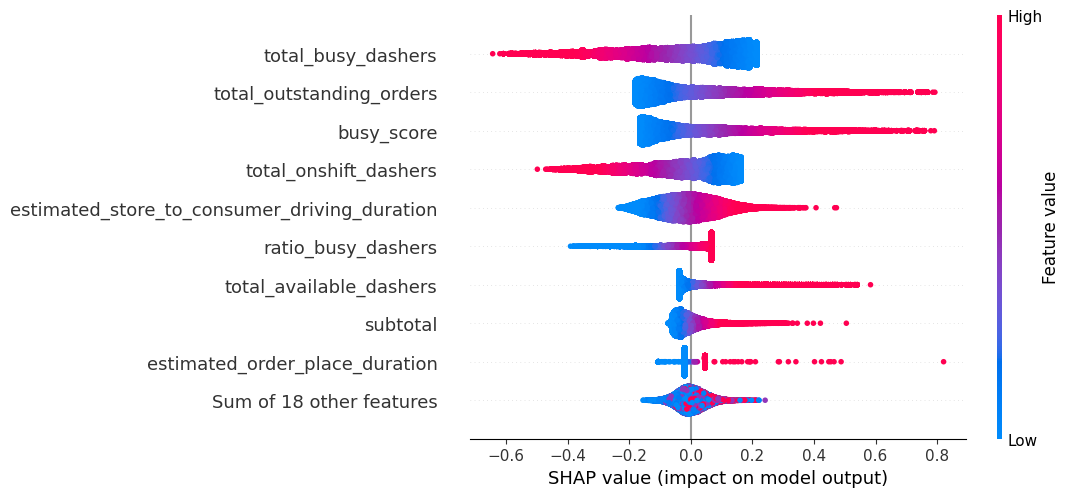

In [34]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

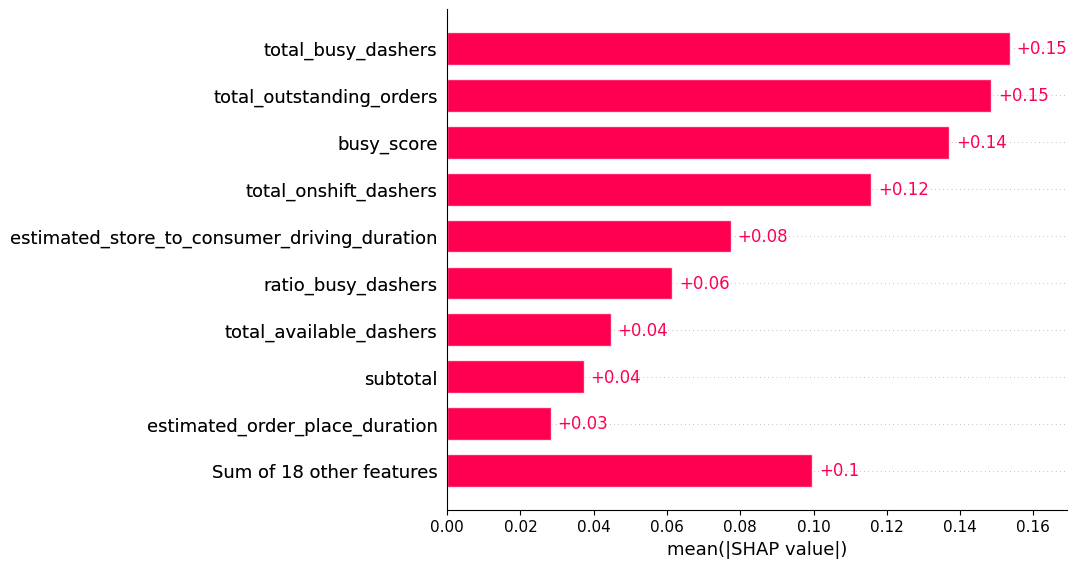

In [35]:
shap.plots.bar(shap_values)

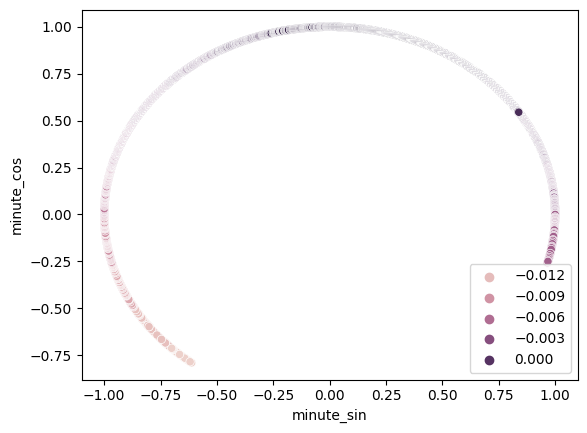

In [58]:
# EXPERIMENTAL: Plot cyclical minute feature's SHAP contributions
shap_sin = shap_values[:, -8]
shap_cos = shap_values[:, -7]
_ = sns.scatterplot(data = X_train, x = "minute_sin", y = "minute_cos", hue = (shap_sin + shap_cos))

- Bottom right: ~7AM

- Top: ~12AM

- Bottom left: ~14:30PM

# Findings

- Performance a bit better than fixed effects GLM, even though the latter was regularized. Close to fixed effects XGB and LGBM. Better than GPBoost1 and GPBoost2.
- SHAP contributions of features are fairly similar to fixed effects GLM.
- In GPBoost1 & 2, the covariance parameters for store_id was much larger than store_primary category. Now it's the other way around.